# Subset Gridded Forcing Data

There are several gridded forcing data products available on HydroData.  Forcing data products are temporally complete gridded datasets of meterological variables that can be used to drive hydrologic models.

You see a complete list of the forcing data products available on HydroData [here](https://maurice.princeton.edu/hydroframe/docs/gridded_data.html#dataset-type-forcing). Each forcing product contains at a minimum the following 8 variables: 
- Precipitation 
- Downward longwave radiation
- Downward shortwave radiation
- Specific humidity 
- Air temperature
- East/west wind speed
- North/south wind speed
- Atmospheric pressure

All forcing products are gridded and you can see the projections and spatial resolution on the HydroData documentation page. 

These tools do not provide any re-gridding options. Data will be returned at the spatial and temporal resolution of the initial dataset which is being subset


#### Things to determine before you start
1. Before you start you should browse the [data catalog](https://maurice.princeton.edu/hydroframe/docs/gridded_data.html#dataset-type-forcing) and determine which forcing dataset you would like to subset. 
2. Take note of the dataset name and the grid that is is available on as you will need this information for your subsetting. 
3. Take note of the start and end dates of the dataset as well as the temporal resolution (e.g. hourly, daily) as these will set the limits of what you can subset. 

#### Edits/questions:
- need improved documentation of the grids on the HD read the docs
- see comment in 2.3 need to specify here and in the doc strings for this function what level of HUC (i.e. 2 digit, 4 digit...) the function can handle.  <<< huc_to_ij can accept HUCs of all levels. But if given more than one, all HUCs need to be of the same level (e.g. a list of HUC 8), otherwise the function will warn the user. I also added 10-digit HUCs to your comment below.
- @George please confirm that what I said was correct about the subset forcing function just working with hourly data and defaulting to putting 24 hours of data into a forcing file. <<< confirmed
- @Reed on section 3.2 would you like to add some lines showing writing this out as a single column forcing file? If so please add and just revise the description above it accordingly.
- @George can you please check that all of this runs and that I didn't break anything. Specifically I think 4.1 will need updating to grab one point out of that dataset since its the files would now be gridded and not just for one point.  <<< I made a few edits and it runs now. Look at the comment for 4.1 about picking a point in the HUC. Alternatively, we could plot a colormap for the whole HUC over a day, to have two different kinds of plots at the end, not just two timeseries.
- @Reed -- do you think the plotting examples are good for now or do we need an example of plotting gridded data not just the single column

### 1.  Setup 

In all examples you will need to import the following packages and register your pin in order to have access to the HydroData datasets

If you haven't already refer to getting started instructions for creating your pin.

In [1]:
from subsettools.subsettools import huc_to_ij, subset_forcing, latlon_to_ij
from hf_hydrodata import gridded
from parflow.tools.io import read_pfb
import matplotlib.pyplot as plt
import numpy as np

gridded.register_api_pin("your_email", "your_pin")

### 2. Define your area of interest

We use i,j indices in order to subset the portion of the national files that you would like to subset.  The `latlon_to_ij` function translates the lat-lon bounds to indices in whatever grid system we select and returns a tuple `(imin, jmin, imax, jmax)` of grid indices that define a bounding box containing our region (or point) of interest.

**IMPORTANT NOTE**: *The i,j indices found in this step are based on whatever grid you select (e.g. `conus1` or `conus2`). Its very important that the grid you use in this step is the same as the grid that the forcing files you are subsetting are in or you will end up subsetting a different location than you expect.* 

#### 2.1 Defining bounds to extract data for a single point

In [3]:
lat = 39.8379
lon = -74.3791
# Since we want to subset only a single location, both lat-lon bounds are defined by this point:
latlon_bounds = ([lat, lon],[lat, lon])
ij_column_bounds = latlon_to_ij(latlon_bounds=latlon_bounds, grid="conus2")
print(f"bounding box: {ij_column_bounds}")

bounding box: (4057, 1915, 4057, 1915)


#### 2.2 Defining bounds for a box defined by lat-lon bounds
Just provide the upper and lower latitude and longitude bounds respectively for the area of interest as well as the grid system that you would like to use. 

In [4]:
ij_box_bounds = latlon_to_ij(latlon_bounds=[[37.91, -91.43], [37.34, -90.63]], grid="conus1")
print(f"bounding box: {ij_box_bounds}")

bounding box: (2285, 436, 2358, 495)


#### 2.3 Defining bounds for a HUC watershed
The subsettools `huc_to_ij` function returns a tuple `(imin, jmin, imax, jmax)` of grid indices that define a bounding box containing any HUC. You can provide 2, 4, 6, 8 or 10-digit hucs **@GEORGE- please correct**. For help finding your HUC You can find refer to the[USGS](https://water.usgs.gov/wsc/map_index.html)

In [5]:
ij_huc_bounds = huc_to_ij(huc_list=["14050002"], grid="conus2")
print(f"bounding box: {ij_huc_bounds}")

bounding box: (1225, 1738, 1347, 1811)


### 3.0 Subset the forcing variables
There are two approaches to subsetting forcing data:
-  The `subset_forcing` function will automatically get the forcing data for all 8 forcing variables listed above and will write the data as pfb files into your output directory to be ready for a ParFlow run. You can modify this function to get a smaller list of variables if you would like.  
- The `gridded.get_numpy` function provides more direct access to the HydroData API and can return any subset variables of interest as a numpy array. 

#### 3.1 Subset forcings with the `subset_forcing` function
This approach is recommended if you are planning on using forcings for a ParFlow run. By default, `subset_forcing` will get the data for all 8 forcing variables (API reference [here](https://hydroframesubsettools.readthedocs.io/en/edit-docs/autoapi/subsettools/subsettools/index.html#subsettools.subsettools.subset_forcing)) and write them out as PFBs for a ParFlow-CLM simulation. 

This function will only work with hourly forcing datasets and will default to putting 24 hours of forcing data into a file. 

In addition to writing the files out the function returns a dictionary where the keys are forcing variable names (e.g. 'precipitation', 'air_temp', ...) and the values are list of filepaths where the subset data for that variable were written. We are going to use these paths later to load the data into an array and plot them.

**NOTE:** *As described above the grid that you use here must match the grid that was used to create the ij indices in step 2 and must also be consistent with the grid that the selected dataset is available on*

In [7]:
# Example grabbing all 8 forcing variables
filepaths = subset_forcing(
    ij_huc_bounds,
    grid="conus2",
    start="2012-10-01",
    end="2013-10-01",
    dataset="CW3E",
    write_dir="/home/ga6/subsettools_example",  # "/path/to/your/chosen/directory",
)

# Example grabbing just two forcing variables 
filepaths = subset_forcing(
    ij_huc_bounds,
    grid="conus2",
    start="2012-10-01",
    end="2013-10-01",
    dataset="CW3E",
    write_dir="/home/ga6/subsettools_example",  # "/path/to/your/chosen/directory",
    forcing_vars=('precipitation', 'air_temp',)
)

Reading precipitation pfb sequence
Reading downward_shortwave pfb sequence
Reading downward_longwave pfb sequence
Reading specific_humidity pfb sequence
Reading air_temp pfb sequence
Reading atmospheric_pressure pfb sequence
Reading east_windspeed pfb sequence
Reading north_windspeed pfb sequence
Finished writing north_windspeed to folder
Finished writing downward_longwave to folder
Finished writing specific_humidity to folder
Finished writing downward_shortwave to folder
Finished writing atmospheric_pressure to folder
Finished writing east_windspeed to folder
Finished writing air_temp to folder
Finished writing precipitation to folder
Reading precipitation pfb sequence
Reading air_temp pfb sequence
Finished writing air_temp to folder
Finished writing precipitation to folder


#### 3.2 Subset data using `gridded.get_numpy` function
The `gridded.get_numpy` function is a general function to extract any gridded data from HydroData. Here we illustrate how to use it grab out a set of forcing variables. 

Note that this will just return the data as numpy array's and will not write them out for a ParFlow run so if you use this option and want to run ParFlow some additional steps will be required to write the data out. 

In [8]:
# list the variables that you would like to extract
forcing_vars = ('precipitation',
                'downward_shortwave',
                'downward_longwave',
                'specific_humidity',
                'air_temp',
                'atmospheric_pressure',
                'east_windspeed',
                'north_windspeed'
                )

forcing_data = {}
for var in forcing_vars:
    options = {"dataset": "CW3E",
               "grid": "conus2",
               "period": "hourly",
               "variable": var,
               "start_time": "2012-10-01",
               "end_time": "2013-10-01",
               "grid_bounds": ij_column_bounds
               }
    forcing_data[var] = gridded.get_numpy(options)
    print(f"{var} loaded:", forcing_data[var].shape)

precipitation loaded: (8760, 1, 1)
downward_shortwave loaded: (8760, 1, 1)
downward_longwave loaded: (8760, 1, 1)
specific_humidity loaded: (8760, 1, 1)
air_temp loaded: (8760, 1, 1)
atmospheric_pressure loaded: (8760, 1, 1)
east_windspeed loaded: (8760, 1, 1)
north_windspeed loaded: (8760, 1, 1)


### 4.0 Visualize the data 
If you use the `subset_forcing` data will need to be read in first using the `read_pfb` function. If you use `get_numpy` the data are already available as a numpy array. 

#### 4.1 loading and visualizing data that was written out using the `subset_forcing function`

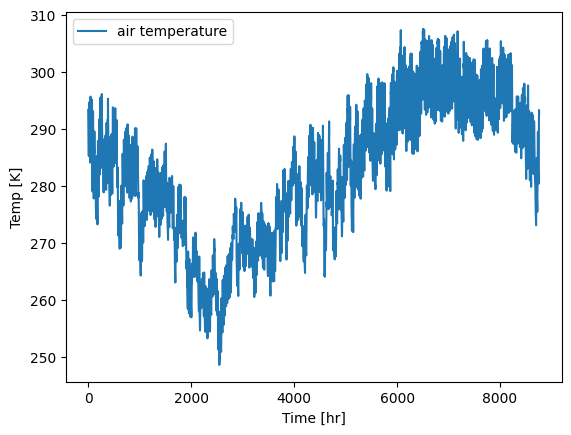

In [14]:
# choose a point in your region and concatenate all data for that point into a single array:
# I'm using the lower left corner (0, 0) just to make the code work here
# we could do something like - choose a latlon point within the HUC, calculate it's offset in the subset array and pick that point?

temp_data = np.array([])
for filepath in filepaths['air_temp']:
    data = read_pfb(filepath).squeeze()
    point_data = data[:, 0, 0]
    temp_data = np.concatenate((temp_data, point_data))

plt.plot(temp_data, label='air temperature')
plt.xlabel('Time [hr]')  
plt.ylabel('Temp [K]')  
plt.legend()
plt.show()

#### 4.2 Visualize data that was subset using `gridded.get_numpy`

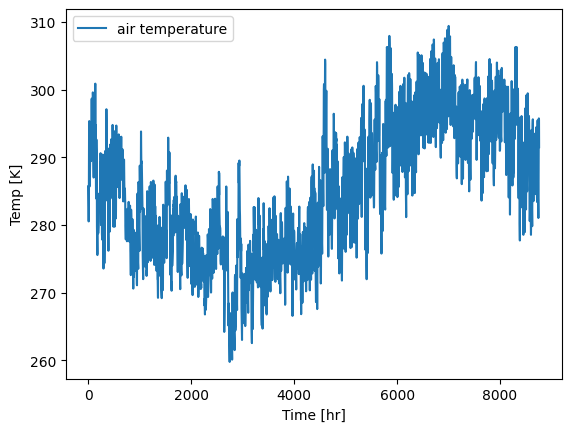

In [9]:
plt.plot(forcing_data['air_temp'].squeeze(), label='air temperature')
plt.xlabel('Time [hr]')
plt.ylabel('Temp [K]')
plt.legend()
plt.show()